In [53]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

In [54]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [55]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [56]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [57]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [58]:
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
all_data.append(numpy_data)
combined_data = np.concatenate(all_data, axis=0)
column_names = ["bvp", "hr", "eda", "temp", "label"]
df = pd.DataFrame(data=combined_data, columns=column_names)

In [59]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
1,-0.49,101.00,2.015176,33.39,0.0
2,-0.49,101.00,2.015176,33.39,0.0
3,-0.49,101.00,2.015176,33.39,0.0
4,-0.49,101.00,2.015176,33.39,0.0
...,...,...,...,...,...
4143995,-6.21,73.65,0.783331,31.81,0.0
4143996,-6.21,73.65,0.783331,31.81,0.0
4143997,-6.21,73.65,0.783331,31.81,0.0
4143998,-6.21,73.65,0.783331,31.81,0.0


In [60]:
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df = df.drop_duplicates()

In [61]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
6,-0.38,101.00,2.015176,33.39,0.0
17,-0.36,101.00,2.015176,33.39,0.0
20,-0.36,106.50,2.015176,33.39,0.0
28,-0.75,106.50,2.015176,33.39,0.0
...,...,...,...,...,...
4143942,-2.09,73.65,0.783331,31.81,0.0
4143951,-3.28,73.65,0.783331,31.81,0.0
4143962,-4.43,73.65,0.783331,31.81,0.0
4143973,-5.44,73.65,0.783331,31.81,0.0


In [62]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## NORMALIZAR E CRIAR MIN, MEAN, MAX


Temperatura

In [63]:
temp_min = []
temp_max = []
temp_mean = []

for i in range(0, len(df), 3):
    temps = df['temp'].iloc[i:i+3]
    temp_min.append(temps.min())
    temp_max.append(temps.max())
    temp_mean.append(temps.mean())

temp_stats = pd.DataFrame({'temp_min': temp_min, 'temp_max': temp_max, 'temp_mean': temp_mean})

In [64]:
temp_min_array = np.array(temp_stats['temp_min'])
normalized_temp_min = preprocessing.normalize([temp_min_array])
temp_max_array = np.array(temp_stats['temp_max'])
normalized_temp_max = preprocessing.normalize([temp_max_array])
temp_mean_array = np.array(temp_stats['temp_mean'])
normalized_temp_mean = preprocessing.normalize([temp_mean_array])


In [65]:
data_temp = {
    'normalized_temp_mean': normalized_temp_mean.flatten(),
    'normalized_temp_max': normalized_temp_max.flatten(),
    'normalized_temp_min': normalized_temp_min.flatten()
}

df_temp = pd.DataFrame(data_temp)
df_temp.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min
0,0.002561,0.002561,0.002561
1,0.002561,0.002561,0.002561
2,0.002561,0.002561,0.002561
3,0.002561,0.002561,0.002559
4,0.002559,0.002559,0.002559



EDA

In [66]:
eda_min = []
eda_max = []
eda_mean = []
for i in range(0, len(df), 3):
    eda = df['eda'].iloc[i:i+3]
    eda_min.append(eda.min())
    eda_max.append(eda.max())
    eda_mean.append(eda.mean())

eda_stats = pd.DataFrame({'eda_min': eda_min, 'eda_max': eda_max, 'eda_mean': eda_mean})

In [67]:
print(eda_stats.head())

    eda_min   eda_max  eda_mean
0  2.015176  2.015176  2.015176
1  2.015176  2.015176  2.015176
2  2.015176  2.015176  2.015176
3  2.012617  2.015176  2.014323
4  2.012617  2.012617  2.012617


In [68]:
eda_min_array = np.array(eda_stats['eda_min'])
normalized_eda_min = preprocessing.normalize([eda_min_array])
eda_max_array = np.array(eda_stats['eda_max'])
normalized_eda_max = preprocessing.normalize([eda_max_array])
eda_mean_array = np.array(eda_stats['eda_mean'])
normalized_eda_mean = preprocessing.normalize([eda_mean_array])


In [69]:
data_eda = {
    'normalized_eda_mean': normalized_eda_mean.flatten(),
    'normalized_eda_max': normalized_eda_max.flatten(),
    'normalized_eda_min': normalized_eda_min.flatten()
}

df_eda = pd.DataFrame(data_eda)
df_eda.head()

,normalized_eda_mean,normalized_eda_max,normalized_eda_min
0,0.004543,0.004542,0.004544
1,0.004543,0.004542,0.004544
2,0.004543,0.004542,0.004544
3,0.004541,0.004542,0.004539
4,0.004537,0.004536,0.004539


HR


In [70]:
hr_min = []
hr_max = []
hr_mean = []
for i in range(0, len(df), 3):
    hr = df['hr'].iloc[i:i+3]
    hr_min.append(hr.min())
    hr_max.append(hr.max())
    hr_mean.append(hr.mean())

hr_stats = pd.DataFrame({'hr_min': hr_min, 'hr_max': hr_max, 'hr_mean': hr_mean})

hr_min_array = np.array(hr_stats['hr_min'])
normalized_hr_min = preprocessing.normalize([hr_min_array])
hr_max_array = np.array(hr_stats['hr_max'])
normalized_hr_max = preprocessing.normalize([hr_max_array])
hr_mean_array = np.array(hr_stats['hr_mean'])
normalized_hr_mean = preprocessing.normalize([hr_mean_array])

In [71]:
data_hr = {
    'normalized_hr_mean': normalized_hr_mean.flatten(),
    'normalized_hr_max': normalized_hr_max.flatten(),
    'normalized_hr_min': normalized_hr_min.flatten()
}

df_hr = pd.DataFrame(data_hr)
df_hr.head()

,normalized_hr_mean,normalized_hr_max,normalized_hr_min
0,0.003260,0.003259,0.003262
1,0.003438,0.003436,0.003440
2,0.003198,0.003436,0.003079
3,0.003077,0.003076,0.003079
4,0.002968,0.003076,0.002915


In [72]:
df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
158904,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002401,0.002400,0.002402
158905,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002394,0.002400,0.002391
158906,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002390,0.002389,0.002391
158907,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379
158908,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379


In [73]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})

Random Forest

In [74]:
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)


#### knn

In [75]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

In [76]:
k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")

k_nearest_neighbors.fit(X_train, y_train.ravel())

y_pred_knn = k_nearest_neighbors.predict(X_test)
f1score   = f1_score        (y_test, y_pred_knn, average = 'macro')
recall    = recall_score    (y_test, y_pred_knn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_knn)
AUC       = roc_auc_score   (y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.991591047189687
acc = 0.9490067753235584
f1 = 0.9442958738494482
recall = 0.9461815087771754


#### Logistic Regression

In [77]:
logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)

logistic_regression.fit(X_train, y_train.ravel())

y_pred_lr = logistic_regression.predict(X_test)
f1score   = f1_score        (y_test, y_pred_lr, average = 'macro')
recall    = recall_score    (y_test, y_pred_lr, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_lr)
AUC       = roc_auc_score   (y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.7752635523657919
acc = 0.47582489039917775
f1 = 0.12896513495458875
recall = 0.2


#### RF

In [78]:

#clf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.999578261291196
acc = 0.9841209909172907
f1 = 0.98291785159033
recall = 0.9845893327196353


#### neural network

In [79]:
neural_network = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)

neural_network.fit(X_train, y_train.ravel())

y_pred_nn = neural_network.predict(X_test)
f1score   = f1_score        (y_test, y_pred_nn, average = 'macro')
recall    = recall_score    (y_test, y_pred_nn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_nn)
AUC       = roc_auc_score   (y_test.ravel(), neural_network.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall) 

auc = 0.9279480632334902
acc = 0.6728127032072662
f1 = 0.43858718334904323
recall = 0.4419589909938866


c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(


#### SVM

In [80]:
support_vector_machine = SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
support_vector_machine.fit(X_train, y_train.ravel())
y_pred_svm = support_vector_machine.predict(X_test)

f1score   = f1_score        (y_test, y_pred_svm, average = 'macro')
recall    = recall_score    (y_test, y_pred_svm, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_svm)
AUC       = roc_auc_score   (y_test.ravel(), support_vector_machine.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall) 

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=9999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


auc = 0.7967989090608839
acc = 0.3615044154972416
f1 = 0.2956723635708373
recall = 0.3939929898922237


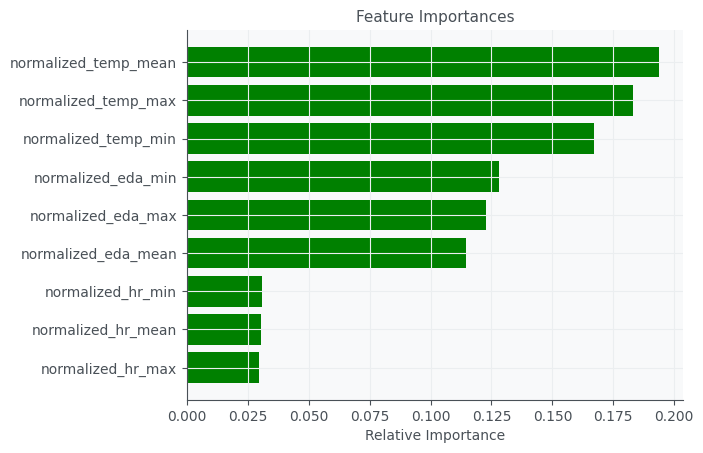

In [81]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

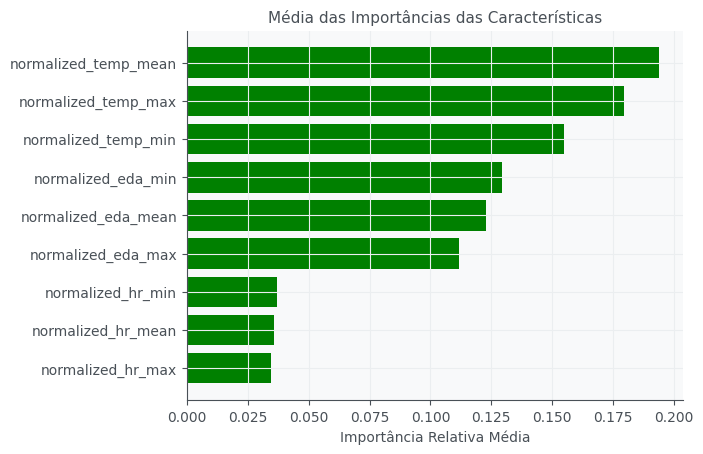

In [82]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()

# Criação de datasets individuais

In [83]:
dfs = {}
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)
    
    user_data = []

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    eda = obj['signal']['wrist']['EDA'][:, 0]
                    temp = obj['signal']['wrist']['TEMP'][:, 0]
                    label = obj['label']

                    len_label = len(label)
                    len_temp_eda = len(temp)

                    total_time = len_label / fs_label

                    time_label = np.linspace(0, total_time, len_label, endpoint=False)
                    time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)

                    interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
                    interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')

                    aligned_temp = interp_temp(time_label)
                    aligned_eda = interp_eda(time_label)

                    user_data.append((aligned_eda, aligned_temp, label))

    # Processar os dados de frequência cardíaca (HR)
    hr_data = []
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

    if hr_data:
        combined_hr_df = pd.concat(hr_data, ignore_index=True)
        hr = combined_hr_df.iloc[:, 0].to_numpy()

        len_hr = len(hr)
        time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
        interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
        aligned_hr = interp_hr(time_label)

        for eda, temp, label in user_data:
            numpy_data = np.column_stack((aligned_hr, eda, temp, label))
            # Adicionar os dados ao dataframe específico do usuário
            if folder_name not in dfs:
                dfs[folder_name] = []
            dfs[folder_name].append(numpy_data)

# Processar cada dataframe de usuário para calcular e normalizar as estatísticas
for key in dfs:
    combined_data = np.concatenate(dfs[key], axis=0)
    column_names = ["hr", "eda", "temp", "label"]
    df = pd.DataFrame(data=combined_data, columns=column_names)
    
    # Filtrar os dados com base nos rótulos desejados
    df = df[df['label'] != 7.0]
    df = df[df['label'] != 6.0]
    df = df[df['label'] != 5.0]
    df = df.drop_duplicates()
    
    # Função para calcular estatísticas e normalizar
    def calculate_and_normalize_stats(df, column):
        min_vals, max_vals, mean_vals = [], [], []
        for i in range(0, len(df), 3):
            vals = df[column].iloc[i:i+3]
            min_vals.append(vals.min())
            max_vals.append(vals.max())
            mean_vals.append(vals.mean())
        stats_df = pd.DataFrame({f'{column}_min': min_vals, f'{column}_max': max_vals, f'{column}_mean': mean_vals})
        normalized_mean = preprocessing.normalize([stats_df[f'{column}_mean'].to_numpy()]).flatten()
        normalized_max = preprocessing.normalize([stats_df[f'{column}_max'].to_numpy()]).flatten()
        normalized_min = preprocessing.normalize([stats_df[f'{column}_min'].to_numpy()]).flatten()
        return pd.DataFrame({f'normalized_{column}_mean': normalized_mean,
                            f'normalized_{column}_max': normalized_max,
                            f'normalized_{column}_min': normalized_min})

    # Calcular e normalizar estatísticas para temperatura, EDA e HR
    df_temp = calculate_and_normalize_stats(df, 'temp')
    df_eda = calculate_and_normalize_stats(df, 'eda')
    df_hr = calculate_and_normalize_stats(df, 'hr')

    # Combinar os dataframes normalizados
    df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
    
    # Calcular a média dos labels para cada janela de 3 amostras
    label_mean = []
    for i in range(0, len(df), 3):
        label = df['label'].iloc[i:i+3] 
        label_mean.append(label.mean())
    label_stats = pd.DataFrame({'label_mean': label_mean})
    
    # Armazenar o dataframe normalizado no dicionário
    dfs[key] = pd.concat([df_normalizado, label_stats], axis=1)
    dfs[key] = dfs[key].drop_duplicates()

# Criar variáveis individuais dfs2 a dfs17
for i in range(2, 11):
    globals()[f'dfs{i}'] = dfs[f'S{i}']
for i in range(13, 18):
    globals()[f'dfs{i}'] = dfs[f'S{i}']

In [84]:
dfs2.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min,label_mean
7937,0.011162,0.011161,0.011163,0.001385,0.001381,0.001379,0.012163,0.012217,0.012141,0.0
7938,0.011162,0.011161,0.011163,0.001298,0.001303,0.001300,0.012260,0.012317,0.012236,0.0
7939,0.011162,0.011161,0.011163,0.001289,0.001303,0.001273,0.012361,0.012418,0.012337,0.0
7940,0.011168,0.011167,0.011169,0.001315,0.001485,0.001220,0.012428,0.012418,0.012437,0.0
7941,0.011168,0.011167,0.011169,0.000922,0.000914,0.000930,0.012428,0.012418,0.012437,0.0


### aplicando series temporais

In [85]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn import metrics

In [86]:
X = dfs2.drop(columns=["label_mean"]) 
y = dfs2["label_mean"].astype(int)
X_train_skt, X_test_skt, y_train_skt, y_test_skt = temporal_train_test_split(X, y, test_size=0.3)
X_train_array = X_train_skt.values
X_test_array = X_test_skt.values
print("X_train_array shape:", X_train_array.shape)
print("X_test_array shape:", X_test_array.shape)

X_train_array shape: (5559, 9)
X_test_array shape: (2383, 9)


In [87]:

tsf = TimeSeriesForestClassifier(n_estimators=50, random_state=47)
tsf.fit(X_train_array, y_train_skt)

tsf_preds = tsf.predict(X_test_array)
print("TSF Accuracy: " + str(metrics.accuracy_score(y_test_skt, tsf_preds)))

TSF Accuracy: 0.44020142677297525


### criando a coluna de timestamps

In [88]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier(num_kernels=2000)
rocket.fit(X_train_array, y_train_skt)
y_pred = rocket.predict(X_test_array)



In [89]:
acc = accuracy_score(y_test_skt, y_pred)
acc

0.26563155686109946

### usar rf nos datasets individuais

In [90]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)
    


 Dataset: dfs2
auc = 0.517235118293142
acc = 0.423444976076555
f1 = 0.18527597915931926
recall = 0.2378011075914143

 Dataset: dfs3
auc = 0.44569667340413704
acc = 0.1967741935483871
f1 = 0.09082198271198708
recall = 0.1234041780705454

 Dataset: dfs4
auc = 0.4863636132953575
acc = 0.29369997418022203
f1 = 0.13816819884235615
recall = 0.25021520803443326

 Dataset: dfs5
auc = 0.5830062448816314
acc = 0.6212036934030482
f1 = 0.2969507856966097
recall = 0.3351682920505958

 Dataset: dfs6
auc = 0.5582626625309957
acc = 0.545704272046983
f1 = 0.23538130616284153
recall = 0.3219227426277542

 Dataset: dfs7
auc = 0.5
acc = 0.42117617988633554
f1 = 0.1185429887855342
recall = 0.2

 Dataset: dfs8
auc = 0.5
acc = 0.4535840188014101
f1 = 0.12481810832659661
recall = 0.2

 Dataset: dfs9
auc = 0.5494711169303752
acc = 0.5325251330573625
f1 = 0.25720940085768085
recall = 0.2934174880314738

 Dataset: dfs10
auc = 0.5935298235119904
acc = 0.5008203445447088
f1 = 0.24375797532722604
recall = 0.334478

In [91]:
for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs13
auc = 0.5084732604815517
acc = 0.46677305368745015
f1 = 0.17011124048313153
recall = 0.22302625885427707

 Dataset: dfs14
auc = 0.49989129632054724
acc = 0.4540481400437637
f1 = 0.12490594431903687
recall = 0.19986240110079118

 Dataset: dfs15
auc = 0.5347487364494836
acc = 0.5218390804597701
f1 = 0.2631866586296966
recall = 0.3061771399751154

 Dataset: dfs16
auc = 0.6250576594382669
acc = 0.6326172138900149
f1 = 0.325975883317955
recall = 0.3862765212783207

 Dataset: dfs17
auc = 0.5
acc = 0.48464859678579997
f1 = 0.1305759754422813
recall = 0.2


### testando o knn

In [92]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.517235118293142
acc = 0.2280282044824981
f1 = 0.1449718932271763
recall = 0.2070540163914119

 Dataset: dfs3
auc = 0.44569667340413704
acc = 0.2294044665012407
f1 = 0.16367826874512809
recall = 0.29219239480545883

 Dataset: dfs4
auc = 0.4863636132953575
acc = 0.14304156984249936
f1 = 0.07143776494404405
recall = 0.21166905786704926

 Dataset: dfs5
auc = 0.5830062448816314
acc = 0.3143842474135054
f1 = 0.1529238440169418
recall = 0.2290396817197426

 Dataset: dfs6
auc = 0.5582626625309957
acc = 0.18044899119067917
f1 = 0.10468375280747391
recall = 0.13200486606997303

 Dataset: dfs7
auc = 0.5
acc = 0.41018038052878675
f1 = 0.20274804493900406
recall = 0.28607564020281717

 Dataset: dfs8
auc = 0.5
acc = 0.27893654524089306
f1 = 0.12926545120835703
recall = 0.23048861308591398

 Dataset: dfs9
auc = 0.5494711169303752
acc = 0.2440863394441159
f1 = 0.12930855789883142
recall = 0.15859781918948576

 Dataset: dfs10
auc = 0.5935298235119904
acc = 0.09133169264424391
f1

In [93]:
for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs13
auc = 0.5084732604815517
acc = 0.3230365895360766
f1 = 0.15246574027259122
recall = 0.24473554540616088

 Dataset: dfs14
auc = 0.49989129632054724
acc = 0.3927789934354486
f1 = 0.1882707832977201
recall = 0.27406394774815823

 Dataset: dfs15
auc = 0.5347487364494836
acc = 0.23505747126436782
f1 = 0.12508262920238827
recall = 0.16589757346749096

 Dataset: dfs16
auc = 0.6250576594382669
acc = 0.10728279962167275
f1 = 0.05981843478875737
recall = 0.04672126803842397

 Dataset: dfs17
auc = 0.5
acc = 0.13756296473974575
f1 = 0.0652499742629383
recall = 0.1048257725180802


### logistic regression

In [94]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_lr = logistic_regression.predict(X)
    f1score = f1_score(y, y_pred_lr, average='macro')
    recall = recall_score(y, y_pred_lr, average='macro')
    accuracy = accuracy_score(y, y_pred_lr)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_lr = logistic_regression.predict(X)
    f1score = f1_score(y, y_pred_lr, average='macro')
    recall = recall_score(y, y_pred_lr, average='macro')
    accuracy = accuracy_score(y, y_pred_lr)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.517235118293142
acc = 0.4687736086628053
f1 = 0.1508265685905968
recall = 0.1880990887055271

 Dataset: dfs3
auc = 0.44569667340413704
acc = 0.5112903225806451
f1 = 0.17745023770382548
recall = 0.2138091264512904

 Dataset: dfs4
auc = 0.4863636132953575
acc = 0.5213013168086754
f1 = 0.150615441999254
recall = 0.19311334289813487

 Dataset: dfs5
auc = 0.5830062448816314
acc = 0.48748470352653245
f1 = 0.1391331957453564
recall = 0.18666666666666668

 Dataset: dfs6
auc = 0.5582626625309957
acc = 0.5849199583214928
f1 = 0.1570847112693971
recall = 0.19734739533397253

 Dataset: dfs7
auc = 0.5
acc = 0.42117617988633554
f1 = 0.1185429887855342
recall = 0.2

 Dataset: dfs8
auc = 0.5
acc = 0.4049647473560517
f1 = 0.1263482048971008
recall = 0.17864275816363415

 Dataset: dfs9
auc = 0.5494711169303752
acc = 0.3710821998817268
f1 = 0.11853600944510034
recall = 0.17127260320709656

 Dataset: dfs10
auc = 0.5935298235119904
acc = 0.3921246923707957
f1 = 0.12364733778831645
r

### neural network

In [95]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_nn = neural_network.predict(X)
    f1score = f1_score(y, y_pred_nn, average='macro')
    recall = recall_score(y, y_pred_nn, average='macro')
    accuracy = accuracy_score(y, y_pred_nn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_nn = neural_network.predict(X)
    f1score = f1_score(y, y_pred_nn, average='macro')
    recall = recall_score(y, y_pred_nn, average='macro')
    accuracy = accuracy_score(y, y_pred_nn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.517235118293142
acc = 0.2547217325610677
f1 = 0.11665452949041155
recall = 0.2130150830431657

 Dataset: dfs3
auc = 0.44569667340413704
acc = 0.21575682382133995
f1 = 0.09535710503073883
recall = 0.1845519826259651

 Dataset: dfs4
auc = 0.4863636132953575
acc = 0.18783888458559256
f1 = 0.080648610494092
recall = 0.21099952175992348

 Dataset: dfs5
auc = 0.5830062448816314
acc = 0.22505284236288797
f1 = 0.09608831112810408
recall = 0.21635782747603835

 Dataset: dfs6
auc = 0.5582626625309957
acc = 0.21066590887562756
f1 = 0.0946620282945203
recall = 0.22320230105465005

 Dataset: dfs7
auc = 0.5
acc = 0.2631578947368421
f1 = 0.10677936152503638
recall = 0.21630976826048695

 Dataset: dfs8
auc = 0.5
acc = 0.2739424206815511
f1 = 0.12485038800904089
recall = 0.2315904024581275

 Dataset: dfs9
auc = 0.5494711169303752
acc = 0.29745712596096985
f1 = 0.1375384933153072
recall = 0.23889457523029684

 Dataset: dfs10
auc = 0.5935298235119904
acc = 0.25649439431227783
f1 =

#### SVM

In [96]:
for i in range(2, 11):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_svm = support_vector_machine.predict(X)
    f1score = f1_score(y, y_pred_svm, average='macro')
    recall = recall_score(y, y_pred_svm, average='macro')
    accuracy = accuracy_score(y, y_pred_svm)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

for i in range(13, 18):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_svm = support_vector_machine.predict(X)
    f1score = f1_score(y, y_pred_svm, average='macro')
    recall = recall_score(y, y_pred_svm, average='macro')
    accuracy = accuracy_score(y, y_pred_svm)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.517235118293142
acc = 0.35696298161672124
f1 = 0.14501984883914293
recall = 0.17430749346222496

 Dataset: dfs3
auc = 0.44569667340413704
acc = 0.5468982630272953
f1 = 0.2224754111967243
recall = 0.26424072405528076

 Dataset: dfs4
auc = 0.4863636132953575
acc = 0.4805060676478182
f1 = 0.14315384615384616
recall = 0.17800095648015304

 Dataset: dfs5
auc = 0.5830062448816314
acc = 0.22082545333185005
f1 = 0.08876845018206955
recall = 0.0870997081911163

 Dataset: dfs6
auc = 0.5582626625309957
acc = 0.2833191247513498
f1 = 0.10031863156129465
recall = 0.09558964525407479

 Dataset: dfs7
auc = 0.5
acc = 0.2222634049913516
f1 = 0.0747440448346077
recall = 0.19343796468121802

 Dataset: dfs8
auc = 0.5
acc = 0.28363689776733253
f1 = 0.12597796290821892
recall = 0.1585062959392698

 Dataset: dfs9
auc = 0.5494711169303752
acc = 0.0702247191011236
f1 = 0.03428983937917344
recall = 0.032412146025247356

 Dataset: dfs10
auc = 0.5935298235119904
acc = 0.17404976756904567
f1

#### Treinando e testando RF no s2 para comparacao com as metricas do s2 rodado com rf do dataset conjunto

In [97]:
train_set = dfs2.drop(columns=["label_mean"])
labels = dfs2["label_mean"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

In [98]:
clfind = RandomForestClassifier(n_estimators=100,max_depth=15)
clfind.fit(X_train, y_train.ravel())
y_pred_rf = clfind.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clfind.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9991795155558586
acc = 0.9819555182543013
f1 = 0.975898669452878
recall = 0.9777778208832174
